# Reduced GUTS model

The scaled damage guts model is fitted to internal concentrations and survival data and models damage as a scaled quantity with a fixed rate constant.

## Imports

First, I apply some modifications to the jupyter notebook for a cleaner experience.
Warnigns are ignored, the root directory is changed to the base of the repository.
Then relevant packages are imported for the case study and its evaluation

In [3]:
import os
import json
import warnings
from functools import partial

import numpy as np
import jax.numpy as jnp
import arviz as az
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpyro.distributions as dist
import numpyro

from pymob.utils.store_file import prepare_casestudy

warnings.filterwarnings("ignore")
os.chdir("/home/flo-schu/projects/damage-proxy")

In [10]:
config = prepare_casestudy(
    case_study=("guts", "guts_reduced"),
    config_file="settings.cfg"
)
from case_studies.guts.sim import SingleSubstanceSim2
from case_studies.guts.prob import model_guts_reduced
from case_studies.guts.mod import tktd_guts_reduced

In [8]:
# Knapp data are IDs 37, 38, 39
sim = SingleSubstanceSim2(config=config)
sim.model = tktd_guts_reduced

MinMaxScaler(variable=cext, min=0.0, max=514.382187237679)
MinMaxScaler(variable=survival, min=0.0, max=18.0)


## Parameter inference

Parameter inference estimates the value of the parameters given the data 
presented to the model.

Here we calculate a maximum a posteriori (MAP) estimate which is the mode
of the posterior distribution.

In [9]:
# set up the inferer properly
sim.set_inferer("numpyro")


First of all prior predictions are generated. These are helpful to diagnose
the model and also to compare posterior parameter estimates with the prior
distributions. If there is a large bias, this information can help to achieve
a better model fit. We can speed up the prior predictive sampling, if we let
the model only sample the prior distributions `only_prior=True`

In [12]:
# set the inference model
sim.inferer.inference_model = partial(model_guts_reduced, only_prior=True)
sim.coordinates["time"] = sim.observations.time.values

# prior predictions
seed = int(np.random.random_integers(0, 100, 1))
prior_predictions = sim.inferer.prior_predictions(n=4000, seed=seed)

In the next step, we take the full model, including deterministic ODE solution
and error model and run our MAP estimator on it, with the parameters that have
been setup before.

    Trace Shapes:         
     Param Sites:         
    Sample Sites:         
    k_d_norm dist      3 |
            value      3 |
      z_norm dist      3 |
            value      3 |
    h_b_norm dist      3 |
            value      3 |
     kk_norm dist      3 |
            value      3 |
survival_obs dist 202 23 |
            value 202 23 |


100%|██████████| 5000/5000 [00:42<00:00, 118.33it/s, init loss: 10472.4678, avg. loss [4751-5000]: 3795.3889]
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
h_b[0]  0.000  0.000   0.000    0.000      0.000    0.000    2045.0    1634.0   
h_b[1]  0.000  0.000   0.000    0.000      0.000    0.000    2225.0    1963.0   
h_b[2]  0.000  0.000   0.000    0.000      0.000    0.000    2008.0    1976.0   
k_d[0]  0.591  0.476   0.078    1.350      0.010    0.008    2117.0    1730.0   
k_d[1]  0.027  0.005   0.018    0.036      0.000    0.000    1952.0    1669.0   
k_d[2]  0.911  2.764   0.002    2.965      0.060    0.043    2112.0    2030.0   
kk[0]   0.001  0.000   0.000    0.001      0.000    0.000    1795.0    1753.0   
kk[1]   0.033  0.006   0.022    0.045      0.000    0.000    1986.0    1999.0   
kk[2]   1.111  1.190   0.036    2.885      0.026    0.019    2065.0    1906.0   
z[0]    7.487  1.468   4.726   10.073      0.032    0.023    2169.0    1709.0   
z[1]    4.790  0.450   3.986    5.637      0.010    0.007    1833.0    2047.0   
z[2]    1.231  2.237   0.011

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

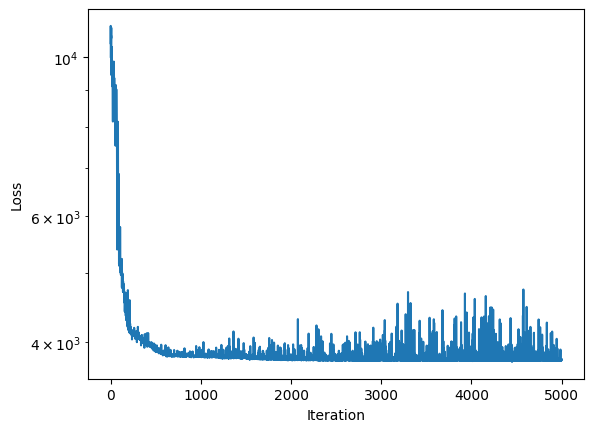

In [20]:
# set the inference model
# choose from SVI, MAP and NUTS

sim.config.set("inference.numpyro", "kernel", "svi")
sim.config.set("inference.numpyro", "svi_iterations", "5000")
sim.config.set("inference.numpyro", "svi_learning_rate", "0.01")
sim.coordinates["time"] = sim.observations.time.values
sim.inferer.inference_model = partial(model_guts_reduced, only_prior=False)
sim.inferer.run()

# show (and explore idata)
sim.inferer.idata

## Posterior predictions

In order to evaluate the goodness of fit for the posteriors, we are looking
at the posterior predictions.

In order to obtain smoother trajectories, the time resolution is increased,
and posterior predictions are calculated.

In [23]:
sim.coordinates["time"] = np.linspace(24, 120, 100)
seed = int(np.random.random_integers(0, 100, 1))

res = sim.inferer.posterior_predictions(n=500, seed=seed).mean(("draw", "chain"))
res

Posterior predictions: 100%|██████████| 500/500 [00:05<00:00, 97.68it/s] 


<xarray.Dataset>
Dimensions:    (id: 202, time: 100)
Coordinates:
  * id         (id) object '101_0' '101_1' '106_0' ... '66_4' '66_5' '6_0'
  * time       (time) float64 24.0 24.97 25.94 26.91 ... 117.1 118.1 119.0 120.0
Data variables:
    D          (id, time) float32 0.0 0.9323 1.408 1.686 ... 339.2 339.3 339.5
    cext       (id, time) float32 2.34 2.34 2.34 2.34 ... 349.5 349.5 349.5
    lethality  (id, time) float32 0.0 2.483e-07 5.001e-07 ... 1.0 1.0 1.0
    survival   (id, time) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0

Next, we plot the predictions against selected experiments. Note that the observations,
may be slightly diverging from the MAP predictions, because
a) the model is not completely correct
b) other data *pull* the posterior estimate away from the displayed data.

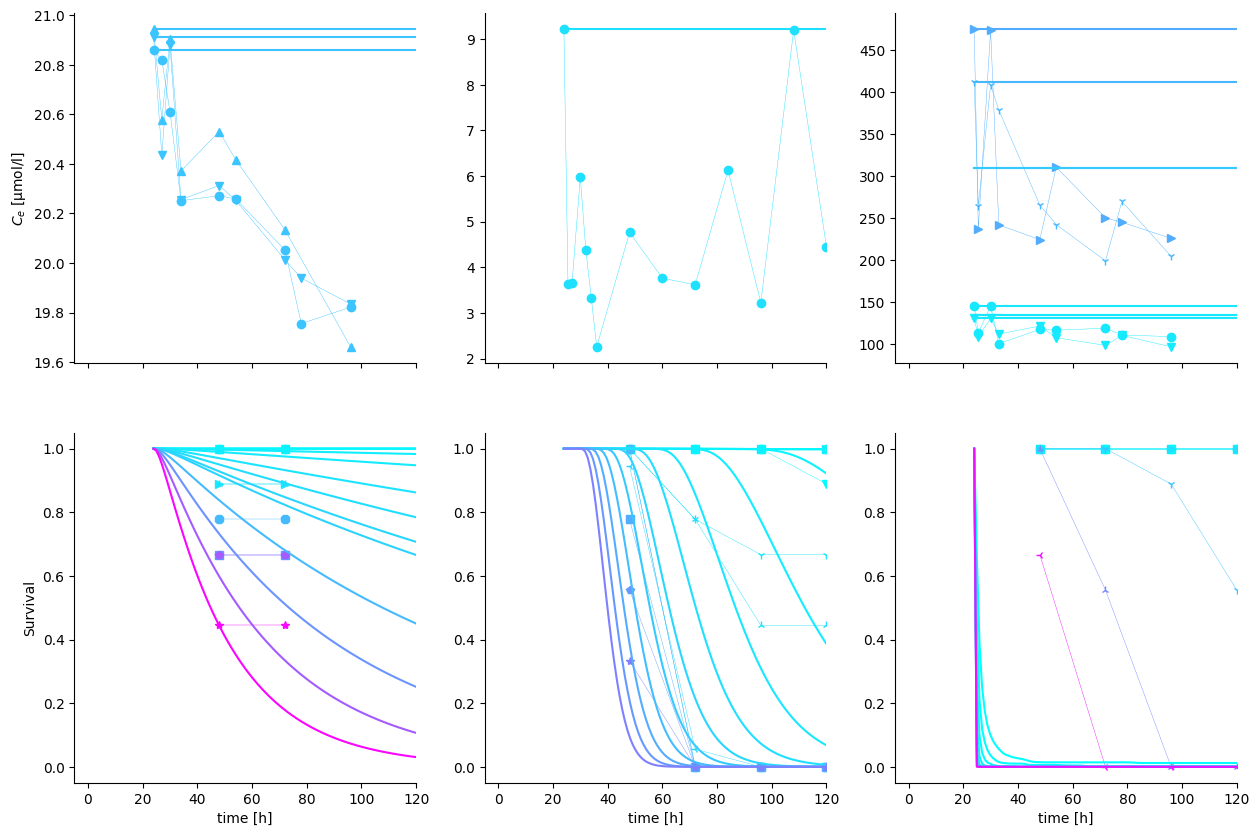

In [24]:
with open(sim.scenario_path + "/experiment_selection_1.json", "r") as fp:
    data_structure = json.load(fp)
    
res = res.assign_coords({"substance": sim.observations.substance})
cmap = mpl.colormaps["cool"]
fig, axes = plt.subplots(len(data_structure), 3, sharex=True, figsize=(15,10))


for r, (v, vdict) in enumerate(data_structure.items()):
    for c, (s, sdict) in enumerate(vdict["substances"].items()):
        sdata = sim.observations.where(sim.observations.substance == s, drop=True)
        C = np.round(sdata.cext_nom.values, 1)
        norm = mpl.colors.Normalize(vmin=C.min(), vmax=C.max())
        for eid in sdict["experiment_ids"]:

            ax, meta, obs_ids, _ = sim.mplot.plot_experiment(
                self=sim,
                experiment_id=eid,
                substance=s,
                data_var=v,
                cmap=cmap,
                norm=norm,
                ax=axes[r, c]
            )

            if v != "survival":
                ax.set_xlabel("")

            if v == "nrf2":
                ax.set_ylim(0, 4)
                # note that the thresholds are mixed up. Diuron and Diclofenac should swap
                z = sim.inferer.idata.posterior.z.mean(("chain", "draw")).values
                ax.hlines(z[c], -10, 120, color="black", lw=0.5)

            if c != 0:
                ax.set_ylabel("")

            l = ax.get_legend()
            if l is not None:
                l.remove()
            ax.set_title("")

            res_ids = sim.get_ids(res, {"substance": s, "experiment_id": eid})

            for i in res_ids:
                y = res.sel(id=i)
                ax.plot(res.time, y[v], color=cmap(norm(y.cext.isel(time=0))))


In the combined model (tktd_rna_3_1), especially NRF2 of Naproxen converges on an
incorrect model dynamic. This is caused (I'm sure) by the substance-indepdendent
threshold parameter $z$ and killing rate $k_k$

## Compare prior and posterior distributions to diagnose biases

We can also look at the prior distributions and the MAP estimate of the posterior
parameter distribution, to assess, whether we are influencing the fit by 
providing a prior that is very far away from the posterior estimate.

In this case-study, the priors should have only a small effect, because of the
large amount of data. Still it is better to be sure.

Since, the parameters are on vastly different scales, they are displayed on the
log-axis.

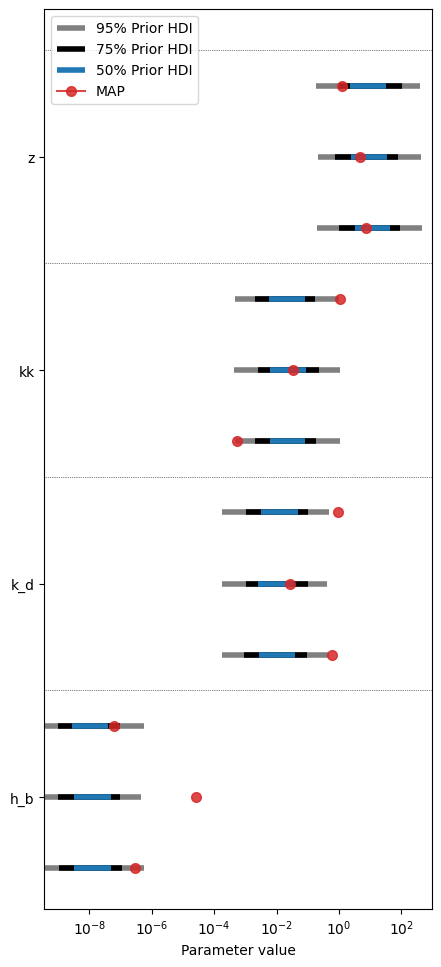

In [25]:
# mpl.use('TkAgg')

substances = sim.observations.attrs["substance"]
priors = prior_predictions.prior.stack(sample=("chain", "draw"))
posteriors = sim.inferer.idata.posterior

hdi_priors_50 = np.exp(az.hdi(np.log(prior_predictions.prior), hdi_prob=0.50))
hdi_priors_75 = np.exp(az.hdi(np.log(prior_predictions.prior), hdi_prob=0.75))
hdi_priors_95 = np.exp(az.hdi(np.log(prior_predictions.prior), hdi_prob=0.95))

fig, ax = plt.subplots(1, 1, figsize=(5, 10))

prior_names = list(priors.data_vars.keys())
xmax = hdi_priors_95.max().to_array().max() * 2
xmin = hdi_priors_95.min().to_array().min() * 2

for k, (key, prior) in enumerate(priors.data_vars.items()):
    nsubstance = len(prior.coords[f"{key}_dim_0"])
    for i in range(nsubstance):
        if nsubstance == 1:
            y = 1
        else:
            y = i

        y_ = k + (y/3 - 1/3)
        h95 = hdi_priors_95[key].isel({f"{key}_dim_0": i})
        h75 = hdi_priors_75[key].isel({f"{key}_dim_0": i})
        h50 = hdi_priors_50[key].isel({f"{key}_dim_0": i})
        posterior_estimate = posteriors[key].mean(("chain", "draw"))
        map_ = posterior_estimate.isel({f"{key}_dim_0": i})

        ax.hlines(y_, *h95, lw=4, color="grey")
        ax.hlines(y_, *h75, lw=4, color="black")
        ax.hlines(y_, *h50, lw=4, color="tab:blue")
        ax.plot(map_, y_, color="tab:red", ms=7, alpha=.85, marker="o")
        if i == 0:
            ax.hlines(k + 0.5, xmin, xmax, ls="dotted", lw=.5, color="black")

ax.set_xscale("log")
ax.set_xlabel("Parameter value")
ax.set_yticks(range(len(prior_names)))
ax.set_yticklabels(prior_names, minor=False)
ax.set_xlim(xmin, xmax)
ax.hlines([], [], [], lw=4, color="grey", label="95% Prior HDI")
ax.hlines([], [], [], lw=4, color="black", label="75% Prior HDI")
ax.hlines([], [], [], lw=4, color="tab:blue", label="50% Prior HDI")
ax.plot([], [], ms=7, alpha=.85, marker="o", color="tab:red", label="MAP")
ax.legend()

fig.subplots_adjust(top=0.95, bottom=0.05)
fig.savefig(f"{sim.output_path}/prior_posterior.png")